In [1]:
import utils
import data_utils as du
import os
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import pandas as pd
from pprint import pprint

# Normalize and resample raw inputs into longitudinal format

In [3]:
inputs = du.clean_longitudinal_inputs(load_pkl=False)


    Loading irregular sequence from disk


    Applying a monthly timestamp to each observation. Each patient's first observation starts with 0. 
    Subsequent observations have a timestamp denoting the number of months since first observation

Data shape: (178166, 55)


# Peek at the data

In [16]:
X = pd.read_pickle('pickles/du2/x_padded_inputs.pkl')
month_count = X.groupby('AUTO_ID').MONTH_TS.count()
print(f"Total sequences: {month_count.sum()}")
print(f"Total sequences above 32mos: {month_count[month_count>64].sum()}")

month_count.describe()

Total sequences: 243549
Total sequences above 32mos: 218354


count    2863.000000
mean       85.067761
std        33.675149
min         1.000000
25%        63.000000
50%       100.000000
75%       113.000000
max       140.000000
Name: MONTH_TS, dtype: float64

## Data Sparsity
- Static variables like AUTO_ID, MONTH_TS etc. are fully populated (0% sparsity)
- Dynamic variables are much more sparse (at least 60% sparsity)
 That is, a majority of our temporally dynamic data is not available

In [21]:
M = pd.read_pickle('pickles/m_missing_mask.pkl')
print("Overall Sparsity:  ", round(M.iloc[:,1:].sum().sum()/(M.shape[0]*(M.shape[1]-1)), 3))
sparsity = 1-(M.sum()/M.shape[0])

Overall Sparsity:0.221


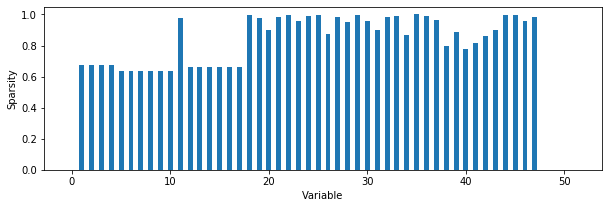

In [19]:
y_pos = range(M.shape[1])
plt.figure(figsize=(10,3))
plt.bar(y_pos, sparsity, width=0.5)
plt.xlabel('Variable')
plt.ylabel('Sparsity')
plt.show()

# Get X and Y TRAIN/VALID/TEST sequences

In [ ]:
du.IBDSequenceGenerator(24,8).write_to_disk('m24p8_HOLDOUT', train_size=0.6)

### Output Log:

        IBDSequenceGenerator.write_to_disk:
         - Reads padded X, M, T matrices
         - Impute according to clinical rules
         - Generate overlapping sequences and {tgt_type} training labels for each patient
         - Scale input sequences
         - Persist sequences as numpy arrays at data/{datadir}/{SEQ_DIR}/{AUTO_ID}_{START_TS}.npy
         - Persist labels for all sequences in data/{datadir}/{SEQ_DIR}/label_dict.pkl
         - Persist empirical mean values at data/{datadir}/x_mean.pkl

# Train

In [ ]:
nohup unbuffer python train.py -b128 -Tannual_charges -Aabnormal_labs,diagnostics,surgery -dm24p8_HOLDOUT -a 0.5 -t 0.0001 -e50 -m24M_mid_lo -lr 0.0001 > models/24M_mid_lo.log & 

nohup unbuffer python train.py -b128 -Tannual_charges -Aabnormal_labs,diagnostics,surgery -dm24p8_HOLDOUT -t 0.5 -a 0.0001 -e50 -m 24M_lo_mid -lr 0.0001 > models/24M_lo_mid.log & 

nohup unbuffer python train.py -b128 -Tannual_charges -Aabnormal_labs,diagnostics,surgery -dm24p8_HOLDOUT -t 0.0001 -a 0.0001 -e50 -m24M_lo_lo -lr 0.0001 > models/24M_lo_lo.log & 

nohup unbuffer python train.py -b128 -Tannual_charges -Aabnormal_labs,diagnostics,surgery -dm24p8_HOLDOUT -t 1 -a 1 -e50 -m24M_hi_hi -lr 0.0001 > models/24M_hi_hi.log & 

# Plot losses by epoch


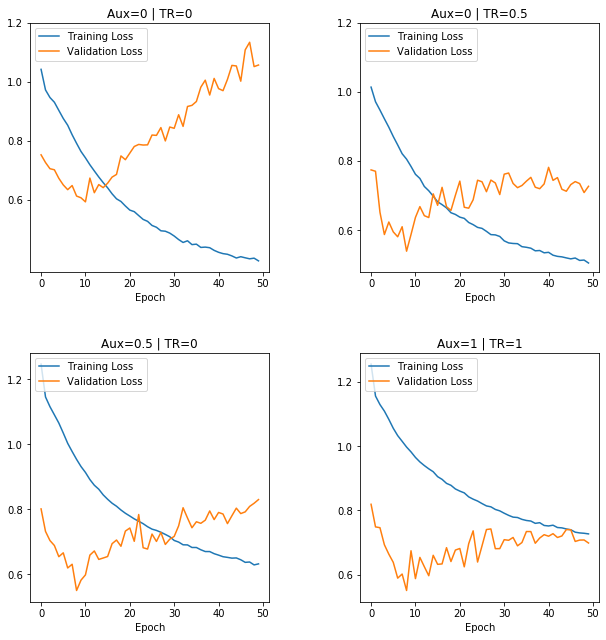

In [79]:
import matplotlib.pyplot as plt
c=0

# Log files to parse from
fi = [x for x in os.listdir('models') if x[-3:]=='log'][:4]
fi = {'24M_lo_lo.log':[0,0], '24M_lo_mid.log':[0,1], '24M_mid_lo.log':[1,0], '24M_hi_hi.log':[1,1]}

titles=["Aux=0 | TR=0", "Aux=0 | TR=0.5", "Aux=0.5 | TR=0", "Aux=1 | TR=1"]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.tight_layout(pad=6)
for ff,[x,y] in fi.items():
    with open(f'models/{ff}','r') as f:
        lines = f.readlines()
    trl = [float(x.split(' ')[6]) for x in lines if 'TrainLoss' in x][:170]
    vl = [float(x.split(' ')[11]) for x in lines if 'TrainLoss' in x][:170]
    ax[x][y].plot(trl, label='Training Loss')
    ax[x][y].plot(vl, label='Validation Loss')
    ax[x][y].legend(loc='upper left')
    ax[x][y].set_title(titles[c])
    ax[x][y].set_xlabel('Epoch')
    # ax[x][y].set_xticks(range(0, 151, 50))
    ax[x][y].set_yticks([0.6,0.8,1,1.2])
    c+=1



In [ ]:
python evaluate2.py -m 24M_lo_lo -Tannual_charges -dm24p8_HOLDOUT
python evaluate2.py -m 24M_hi_hi -Tannual_charges -dm24p8_HOLDOUT
python evaluate2.py -m 24M_lo_mid -Tannual_charges -dm24p8_HOLDOUT
python evaluate2.py -m 24M_mid_lo -Tannual_charges -dm24p8_HOLDOUT


In [53]:
import utils,pprint
pprint.pprint(utils.pkl_load('models/24M_hi_hi_nolap/test_report.dict'))

{'accuracy':0.6776236891746521,
'brier':{0: 0.2884098967858543, 2: 0.07826403107575311},
'clf_report':{'High':{'f1-score':0.2852122986822841,
'precision':0.24228855721393036,
'recall':0.34661921708185056,
'support':1405},
'Low':{'f1-score':0.8132780082987552,
'precision':0.9497118910424306,
'recall':0.7111198274171406,
'support':20396},
'Mid':{'f1-score':0.10061025894771565,
'precision':0.057645057645057646,
'recall':0.3950777202072539,
'support':772},
'accuracy':0.6776237097417268,
'macro avg':{'f1-score':0.39970018864291834,
'precision':0.41654850196713955,
'recall':0.4842722549020817,
'support':22573},
'weighted avg':{'f1-score':0.7560365328852018,
'precision':0.8751712726305307,
'recall':0.6776237097417268,
'support':22573}},
'conf_matrix':[[14504.0, 4536.0, 1356.0],
[300.0, 305.0, 167.0],
[468.0, 450.0, 487.0]],
'imbal_metrics_HC':{'auprc':0.2681,
'precision@recall=0.0':0.5,
'precision@recall=0.1':0.6746411483253588,
'precision@recall=0.2':0.4707846410684474,
'precision@recall=0.3

In [74]:
import utils, pandas as pd
reports = []
for root, directories, filenames in os.walk('models'):
    for filename in filenames: 
        if filename=='test_report.dict' and 'olap' in root:
            reports.append(utils.pkl_load(os.path.join(root,filename)))

lookup = {'hi':1, 'lo':0, 'mid':0.5}
report_card = {}
for report in reports:
    modelname = report['modelname']

    result={}
    if 'nolap' in modelname:
        result['Datasplit'] = 'HO'
        result['Alpha_Aux'] = lookup[modelname.split('_')[1]]
        result['TR_Aux'] = lookup[modelname.split('_')[2]]
    else:
        result['Datasplit'] = 'OL'
        result['Alpha_Aux'] = lookup[modelname.split('_')[2]]
        try:
            result['TR_Aux'] = lookup[modelname.split('_')[3]]
        except:
            print(modelname.split('_'))

    # result['Log Loss'] = report['loss']
    # result['Kappa'] = report['kappa']
    # result['MCC'] = report['mcc']
    # result['AUPRC_High'] = report['imbal_metrics_HC']['auprc'] 
    # result['Recall@Precision=0.3'] = report['imbal_metrics_HC']['recall@precision=0.3'] 
    result['Recall@Precision=0.5'] = report['imbal_metrics_HC']['recall@precision=0.4']
    result['Recall@Precision=0.7'] = report['imbal_metrics_HC']['recall@precision=0.7']
    result['Recall@Precision=0.8'] = report['imbal_metrics_HC']['recall@precision=0.8']
    result['Accuracy'] = report['accuracy']
    result['Brier_LC'] = report['brier'][0]
    result['Brier_HC'] = report['brier'][2]
    report_card[modelname] = result

# pd.DataFrame(report_card).T.to_csv('Last Models.csv')
pd.DataFrame(report_card).T

,Datasplit,Alpha_Aux,TR_Aux,Recall@Precision=0.5,Recall@Precision=0.7,Recall@Precision=0.8,Accuracy,Brier_LC,Brier_HC
24M_hi_hi_nolap,HO,1,1,0.241281,0.0960854,0.0177936,0.677624,0.28841,0.078264
24M_lo_lo_nolap,HO,0,0,0.203559,0,0,0.73331,0.194335,0.102647
24M_lo_mid_nolap,HO,0,0.5,0.119573,0,0,0.606078,0.263326,0.120629
24M_mid_lo_nolap,HO,0.5,0,0.222776,0.0519573,0,0.542418,0.392368,0.104487
olap_24M_hi_hi,OL,1,1,0.211679,0.0410584,0.00228102,0.778555,0.143709,0.06501
olap_24M_lo_lo,OL,0,0,0.182482,0.0346715,0.00228102,0.759378,0.164096,0.0666813
olap_24M_lo_mid,OL,0,0.5,0.228102,0.0606752,0,0.796046,0.117627,0.0614083
olap_24M_mid_lo,OL,0.5,0,0.198449,0.044708,0,0.763282,0.143293,0.0635678
